In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../data/raw/HI-Medium_Trans.csv")

In [3]:
df.shape

(31898238, 11)

In [4]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:17,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/09/01 00:02,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022/09/01 00:17,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022/09/01 00:03,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022/09/01 00:02,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31898238 entries, 0 to 31898237
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 2.6+ GB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
From Bank,31898238.0,2.944094e+05,6.153149e+05,0.000000,2954.00,39024.00,215884.00,3.225455e+06
To Bank,31898238.0,4.093198e+05,6.547003e+05,0.000000,27496.00,146853.00,259893.00,3.225455e+06
Amount Received,31898238.0,6.431116e+06,2.592744e+09,0.000001,207.87,1469.25,11835.30,8.158609e+12
Amount Paid,31898238.0,4.417551e+06,1.848313e+09,0.000001,209.23,1471.54,11757.81,8.158609e+12
Is Laundering,31898238.0,1.104450e-03,3.321491e-02,0.000000,0.00,0.00,0.00,1.000000e+00


In [7]:
df.describe(include='O').T

,count,unique,top,freq
Timestamp,31898238,26086,2022/09/01 00:14,44215
Account,31898238,2013627,100428660,1076979
Account.1,31898238,1689925,100428660,6842
Receiving Currency,31898238,15,US Dollar,11594241
Payment Currency,31898238,15,US Dollar,11688249
Payment Format,31898238,7,Cheque,12280058


####  Insights

- Size: 31.9M rows × 11 columns:  large dataset, memory management will matter.

- Dtypes: 6 object, 3 int, 2 float: some objects (Timestamp, account IDs) should be converted.

- Mising values: appears low overall, but we’ll validate.

- Skew: Amount Received and Amount Paid span from tiny fractions to trillions → strong outliers to handle later.

Categories:

- 15 unique currencies,

- 7 payment formats,

- millions of unique accounts.

Target: Is Laundering is binary (0/1),  good for classification.


#### Next

- Timestamp must be parsed to datetime.

- Currency and payment format can be categorical.

- Accounts are IDs shoulf strings types.

- Outliers will need careful treatment later.


In [8]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

df['Account'] = df['Account'].astype(str)
df['Account.1'] = df['Account.1'].astype(str)
for col in ['Receiving Currency', 'Payment Currency', 'Payment Format']:
    df[col] = df[col].astype('category')



In [9]:
df.dtypes

Timestamp             datetime64[ns]
From Bank                      int64
Account                       object
To Bank                        int64
Account.1                     object
Amount Received              float64
Receiving Currency          category
Amount Paid                  float64
Payment Currency            category
Payment Format              category
Is Laundering                  int64
dtype: object

In [11]:
print("Date range:", df['Timestamp'].min(), "-", df['Timestamp'].max())

Date range: 2022-09-01 00:00:00 - 2022-09-28 15:58:00


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31898238 entries, 0 to 31898237
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   Account             object        
 3   To Bank             int64         
 4   Account.1           object        
 5   Amount Received     float64       
 6   Receiving Currency  category      
 7   Amount Paid         float64       
 8   Payment Currency    category      
 9   Payment Format      category      
 10  Is Laundering       int64         
dtypes: category(3), datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 2.0+ GB


#### Insights
- Timestamp is  stored as datetime64.

- Accounts remain as object  since they are alphanumeric IDs.

- Currencies & Payment Format now category,  efficient for grouping & filtering.

- Memory usage dropped from 2.6 GB to 2.0 GB just from type conversion (around +20% reduction).

Dataset is now  correct schema and clean for the next phase.

#### Next
- check for duplicates, integrity, and ID consistency

In [14]:
dup_rows_total = df.duplicated().sum()
print("Exact duplicate rows:", dup_rows_total)

Exact duplicate rows: 20


In [15]:
duplicate_rows = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))
duplicate_rows


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
8159369,2022-09-03 18:39:00,122407,80E54B721,213589,84EC258A1,0.000002,Bitcoin,0.000002,Bitcoin,Bitcoin,0
8159371,2022-09-03 18:39:00,122407,80E54B721,213589,84EC258A1,0.000002,Bitcoin,0.000002,Bitcoin,Bitcoin,0
9834991,2022-09-05 07:36:00,161430,828C83141,161430,828C83140,0.000001,Bitcoin,0.010000,US Dollar,ACH,0
9834993,2022-09-05 07:36:00,161430,828C83141,161430,828C83140,0.000001,Bitcoin,0.010000,US Dollar,ACH,0
9834992,2022-09-05 07:36:00,161430,828C83141,2213875,851BB5C81,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
9834994,2022-09-05 07:36:00,161430,828C83141,2213875,851BB5C81,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0
13710705,2022-09-07 08:15:00,2597,800AB57E0,2597,800AB57E0,0.050000,Euro,0.060000,US Dollar,ACH,0
13710707,2022-09-07 08:15:00,2597,800AB57E0,2597,800AB57E0,0.050000,Euro,0.060000,US Dollar,ACH,0
15819700,2022-09-08 10:14:00,1313,817576F91,1313,817576F90,0.000001,Bitcoin,0.010000,US Dollar,ACH,0
15819702,2022-09-08 10:14:00,1313,817576F91,1313,817576F90,0.000001,Bitcoin,0.010000,US Dollar,ACH,0


In [16]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)

#### Insights
- Duplicates removed: only 20 rows dropped out of 31M,  negligible in size, but important to avoid bias in training.

#### Next: 
- check for nulls and  negative values,

- validate Amount Paid vs Amount Received logic.

- Amount Paid vs Amount Received to flag inconsistencies.

In [17]:
df[['Amount Paid','Amount Received']].isna().sum()

Amount Paid        0
Amount Received    0
dtype: int64

In [18]:
neg_paid = (df['Amount Paid'] <= 0).sum()
neg_recv = (df['Amount Received'] <= 0).sum()
print("Non-positive Amount Paid:", neg_paid)
print("Non-positive Amount Received:", neg_recv)

Non-positive Amount Paid: 0
Non-positive Amount Received: 0


In [19]:
print("Amount Paid - min/max:", df['Amount Paid'].min(), df['Amount Paid'].max())
print("Amount Received - min/max:", df['Amount Received'].min(), df['Amount Received'].max())


Amount Paid - min/max: 1e-06 8158609321727.61
Amount Received - min/max: 1e-06 8158609321727.61


In [20]:
same_currency = df['Payment Currency'] == df['Receiving Currency']
mismatch_same = (abs(df.loc[same_currency, 'Amount Paid'] - df.loc[same_currency, 'Amount Received']) > 1e-6).sum()
print("Mismatches (same currency):", mismatch_same)

Mismatches (same currency): 0


#### Insight
- The numeric values(Amount Paid, Amount Received) is clean, consistent, and ready for EDA and modeling.

- No imputation or special handling required.

#### Next
- EDA

In [29]:
# class distribution
class_counts= df['Is Laundering'].value_counts()
class_counts

Is Laundering
0    31862988
1       35230
Name: count, dtype: int64

In [ ]:
(df['Is Laundering'].value_counts(normalize=True) * 100).round(4)

Is Laundering
0    99.8896
1     0.1104
Name: proportion, dtype: float64

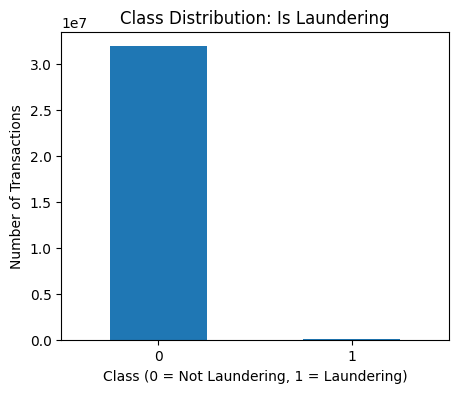

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,4))
class_counts.plot(kind='bar', ax=ax)
ax.set_title("Class Distribution: Is Laundering")
ax.set_xlabel("Class (0 = Not Laundering, 1 = Laundering)")
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel("Number of Transactions")
plt.show()

#### Interpretation

- we highly imbalanced dataset

- `Accuracy as a metric would be misleading`

- We  are prioritize `recall (catching laundering cases) and precision (avoiding false alarms).`

### Decision

For modeling, we’ll need imbalance strategies:

- Resampling: oversample minority (SMOTE) | Undersample majority.

- Algorithmic: tree-based models handle imbalance better (`XGBoost, LightGBM`).

- Evaluation: use precision, recall, F1, ROC-AUC, `not raw accuracy`.

#### Next
- Univariate distributions


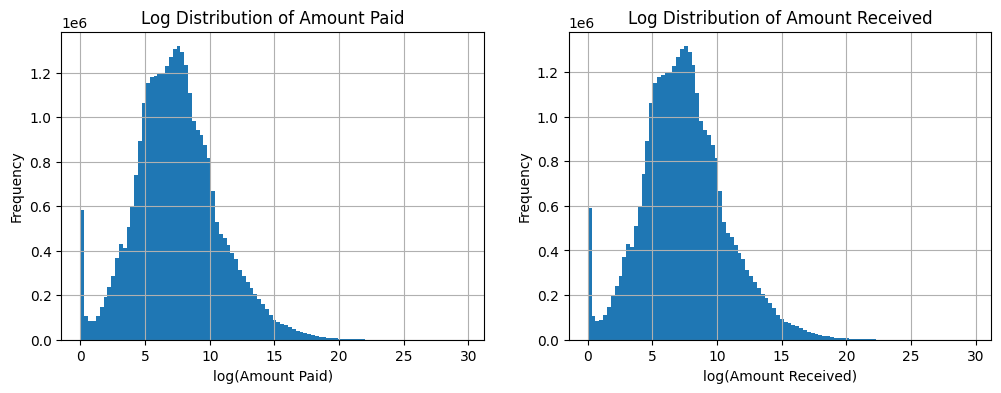

In [38]:
# Amount Paid and Amount Received 
fig, axes = plt.subplots(1, 2, figsize=(12,4))

df['Amount Paid'].apply(lambda x: np.log1p(x)).hist(bins=100, ax=axes[0])
axes[0].set_title("Log Distribution of Amount Paid")
axes[0].set_xlabel("log(Amount Paid)")
axes[0].set_ylabel("Frequency")

df['Amount Received'].apply(lambda x: np.log1p(x)).hist(bins=100, ax=axes[1])
axes[1].set_title("Log Distribution of Amount Received")
axes[1].set_xlabel("log(Amount Received)")
axes[1].set_ylabel("Frequency")

plt.show()

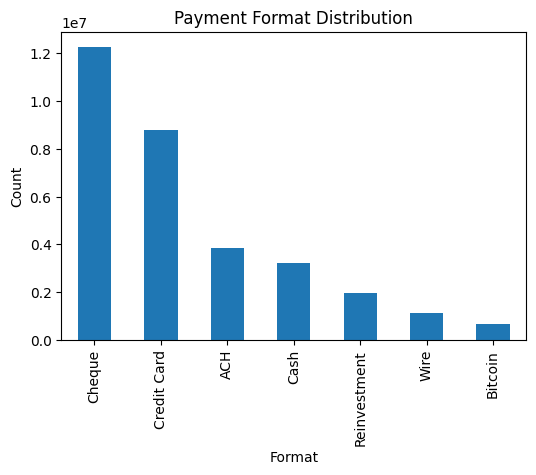

In [40]:
# Payment Format 
format_counts = df['Payment Format'].value_counts()

fig, ax = plt.subplots(figsize=(6,4))
format_counts.plot(kind='bar', ax=ax)
ax.set_title("Payment Format Distribution")
ax.set_xlabel("Format")
ax.set_ylabel("Count")
plt.show()

Text(0, 0.5, 'Count')

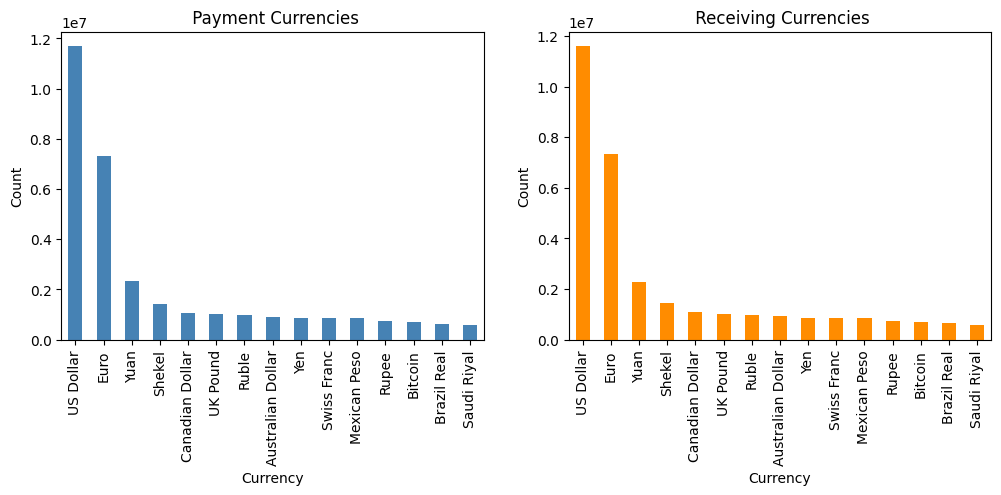

In [49]:

# Payment & Receiving Currencies 
currency_counts = df['Payment Currency'].value_counts()
recv_currency_counts = df['Receiving Currency'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
currency_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title(" Payment Currencies")
axes[0].set_xlabel("Currency")
axes[0].set_ylabel("Count")

recv_currency_counts.plot(kind='bar', ax=axes[1], color='darkorange')
axes[1].set_title(" Receiving Currencies")
axes[1].set_xlabel("Currency")
axes[1].set_ylabel("Count")

#### Insights
- Amounts (Paid & Received, log scale):
    - Strong long-tail distribution: most transactions are small, with a few extremely large ones.
    - Clear peak around log(7–8) → translates to amounts in the thousands.
    - A spike at very small values (0.000001, 0.000002, etc), especially in Bitcoin.
  
- Payment Format:

   - Dominated by Cheque and Credit Card 

   - ACH and Cash are mid-tier.

  - Reinvestment, Wire, and Bitcoin are minority channels.

- Payment & Receiving Currencies:

    - US Dollar dominates, followed by Euro.

    - Others (Yuan, Shekel, Canadian Dollar, UK Pound, etc.) drop off quickly.

    - Bitcoin is in both sender and receiver, but as a minority currency.

Notes for feature engineering:


  - we need to apply log-transform to amounts before training.

  - Collapse minority categories in currencies and formats.

  - Retain categorical mappings for interpretability.

Next: Time-Based Patterns



In [ ]:
#Transactions per day 
df['date'] = df['Timestamp'].dt.date
daily_counts = df.groupby('date').size()
print("Daily transaction counts (sample):")
print(daily_counts.head())

Daily transaction counts (sample):
date
2022-09-01    4465985
2022-09-02    3021258
2022-09-03     828957
2022-09-04     830607
2022-09-05    1928597
dtype: int64


In [51]:
# Laundering rate per day
daily_laundering = df.groupby('date')['Is Laundering'].mean() * 100
print("\nDaily laundering rate (%):")
print(daily_laundering.head())


Daily laundering rate (%):
date
2022-09-01    0.023645
2022-09-02    0.044054
2022-09-03    0.165630
2022-09-04    0.186490
2022-09-05    0.096599
Name: Is Laundering, dtype: float64


In [52]:
# Transactions per hour 
df['hour'] = df['Timestamp'].dt.hour
hourly_counts = df.groupby('hour').size()
hourly_laundering = df.groupby('hour')['Is Laundering'].mean() * 100

In [53]:
print("\nHourly transaction counts (0–23):")
print(hourly_counts)
print("\nHourly laundering rate (%):")
print(hourly_laundering)


Hourly transaction counts (0–23):
hour
0     3372880
1     1238051
2     1237519
3     1240535
4     1241507
5     1240382
6     1238863
7     1241455
8     1238733
9     1242274
10    1238953
11    1244850
12    1241198
13    1238630
14    1244471
15    1237846
16    1240367
17    1240446
18    1241819
19    1238812
20    1241063
21    1239446
22    1239799
23    1238319
dtype: int64

Hourly laundering rate (%):
hour
0     0.032672
1     0.082791
2     0.086544
3     0.080046
4     0.082883
5     0.105451
6     0.105581
7     0.106166
8     0.130456
9     0.130648
10    0.133258
11    0.179379
12    0.178054
13    0.175678
14    0.165291
15    0.162944
16    0.166483
17    0.135355
18    0.132547
19    0.133676
20    0.068651
21    0.066723
22    0.071383
23    0.071306
Name: Is Laundering, dtype: float64


Visualizations

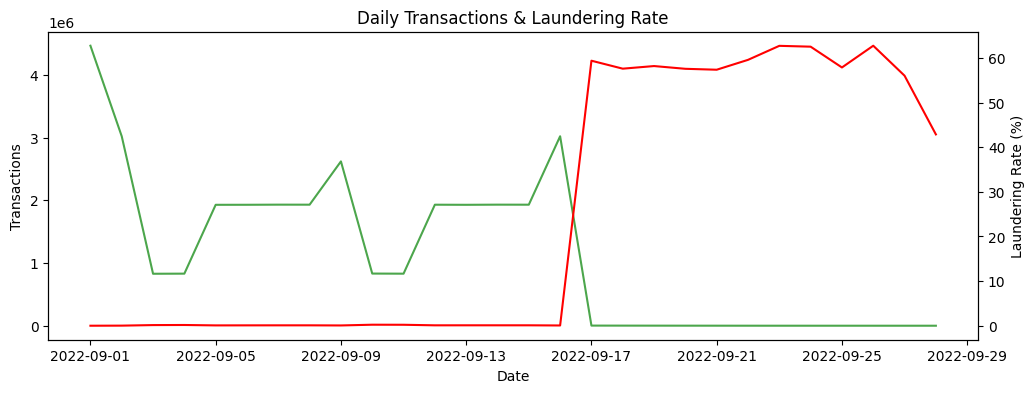

In [55]:

# Daily trends
fig, ax = plt.subplots(figsize=(12,4))
daily_counts.plot(ax=ax, color='green', alpha=0.7, label="Transactions")
daily_laundering.plot(ax=ax, color='red', secondary_y=True, label="Laundering Rate (%)")

ax.set_title("Daily Transactions & Laundering Rate")
ax.set_xlabel("Date")
ax.set_ylabel("Transactions")
ax.right_ax.set_ylabel("Laundering Rate (%)")

plt.show()

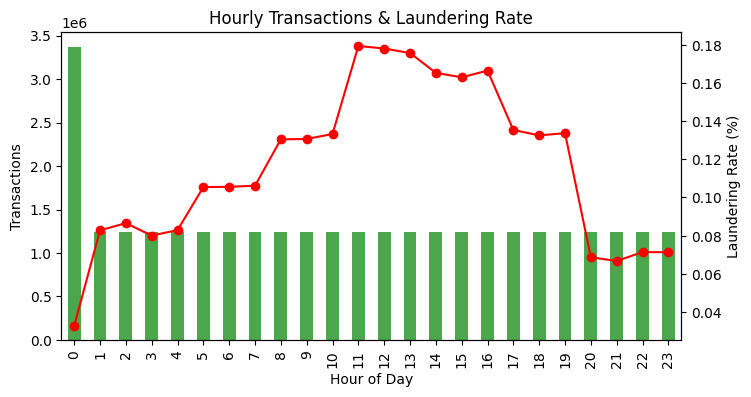

In [56]:
# Hourly pattern
fig, ax = plt.subplots(figsize=(8,4))
hourly_counts.plot(kind='bar', ax=ax, color='green', alpha=0.7)
ax2 = ax.twinx()
hourly_laundering.plot(ax=ax2, color='red', marker='o')
ax.set_title("Hourly Transactions & Laundering Rate")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Transactions")
ax2.set_ylabel("Laundering Rate (%)")

plt.show()

#### Insights

##### Daily Transactions & Laundering Rate 
- Transaction counts are high at the start (Sep 1) but drop sharply after Sep 15.
- Laundering rate (%) spikes after Sep 16.

##### Hourly Transactions & Laundering Rat
- Transaction volume is fairly stable across hours.
- Laundering rate is lowest around midnight.
       
#### Interpretation: 
- laundering cases are time clustered during business hours:  possibly reflecting real world operational activity
- Interpretation: could be dataset cutoff or sampling bias (this is not actual real-world data).

 ##### Note for modeling

- Add temporal features:

- day_of_week, hour (business vs non-business hours) and possibly is_weekend

#### Next
- correlations between numeric features.
- laundering rates vary by categories


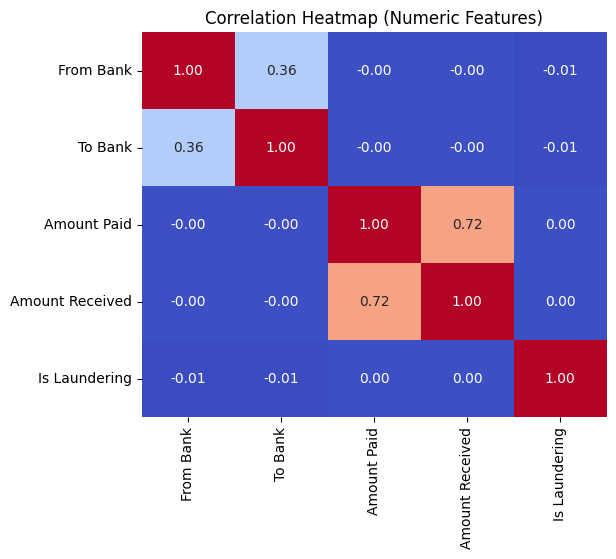

In [57]:
# Correlation heatmap (numeric features)

numeric_cols = ['From Bank','To Bank','Amount Paid','Amount Received','Is Laundering']
corr = df[numeric_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [58]:
# Laundering rate vs Payment Format

format_laundering = df.groupby('Payment Format')['Is Laundering'].mean().sort_values(ascending=False)*100
print("Laundering rate (%) by Payment Format:")
print(format_laundering)

Laundering rate (%) by Payment Format:
Payment Format
ACH             0.794798
Bitcoin         0.035412
Cash            0.020699
Cheque          0.018078
Credit Card     0.015425
Reinvestment    0.000000
Wire            0.000000
Name: Is Laundering, dtype: float64


In [59]:
# Laundering rate by Payment Currency 
currency_laundering = df.groupby('Payment Currency')['Is Laundering'].mean().sort_values(ascending=False)*100
print("\nLaundering rate (%) by Payment Currency:")
print(currency_laundering)


Laundering rate (%) by Payment Currency:
Payment Currency
UK Pound             0.159929
Ruble                0.149355
Euro                 0.132724
Yen                  0.130120
US Dollar            0.122277
Yuan                 0.119066
Rupee                0.112357
Australian Dollar    0.080233
Canadian Dollar      0.056104
Shekel               0.046710
Brazil Real          0.044320
Mexican Peso         0.041129
Saudi Riyal          0.039681
Swiss Franc          0.039071
Bitcoin              0.035419
Name: Is Laundering, dtype: float64


#### Insight 
- By Payment Format (laundering rate %):

    - ACH have 0.79%  highest risk channel.

    - Bitcoin have 0.035%

    - Cash  have 0.021%
- By Payment Currency (laundering rate %):

    - UK Pound:  0.16%

    - Ruble:  0.15%

    - Euro: 0.13%

    - USD also notable (0.12%) given its large share of transactions.


Bitcoin is relatively low (0.035%) despite out expectations

Cheque, Credit Card, Wire, Reinvestment has ery low laundering rates.


#### Note

- Numeric features alone won’t separate laundering cases.

- Strong predictors will come from:

- Payment Format (ACH especially),

- Payment Currency (GBP, Ruble, Euro, USD),

- Temporal features (hour/day patterns).

#### Our Next Step: Preprocessing Plan: We’ll prepare the dataset for modeling:

- scale/log-transform amounts

- encode categorical features (currencies, formats)

- add temporal features (hour, weekday, weekend flag)

- handle class imbalance (resampling).

Thanks you